In [2]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add
import re

import random
import hashlib

from multiprocessing import Pool, cpu_count
from functools import partial


Processing alpha=1, using discriminant: score_hh4bvsboth

[CACHE] Found saved data at maxbin_cache/maxbin_cached_data_alpha1.npz
[CACHE] Loading data directly...
[CACHE] Loaded 841853 signal events.

Data collection completed

Calculating ROC curve...
Total Signal: 398.42, Total BG: 17133594.36, AUC: 0.9884

Creating plot...
Target: 20.000 | Actual: 19.986 | Thresh: 0.999929 | BG: 37.518
Target: 24.763 | Actual: 24.782 | Thresh: 0.999912 | BG: 54.424
Target: 29.483 | Actual: 29.523 | Thresh: 0.999896 | BG: 75.345


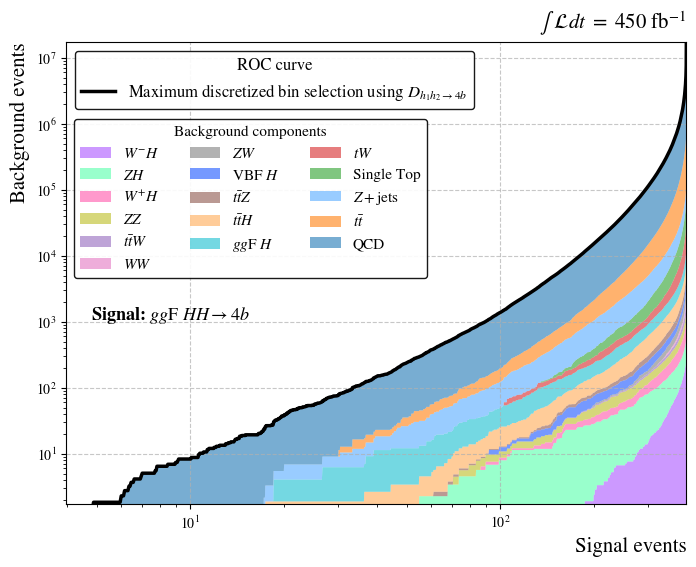


Plot saved successfully!


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import glob
import os
import sklearn.metrics as m
from multiprocessing import Pool, cpu_count
from functools import partial

# ======================================================================================
# Configuration
# ======================================================================================

# --- Cache Settings ---
USE_CACHE = True  # Set to True to load from saved file if available
CACHE_DIR = "maxbin_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"

model_names = [
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1",
    "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2"
]

folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

lumi_scale = 4.5
weight_dict = {
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / ((17600+38072) * 50e5),
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5),
    "TTbar": lumi_scale * 83175900 / (40305472 + 120928855),
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

# ===== QCD Ratio Fit Parameters =====
FIT_A = 7.4287e+02
FIT_B = 2.4671e-05
FIT_C = -742.9684
FIT_T = 6704.6029

def calculate_qcd_ratio(x_control_events):
    # Formula: y = a * (x + t)^b + c
    base = np.maximum(x_control_events + FIT_T, 1e-9)
    ratio = FIT_A * np.power(base, FIT_B) + FIT_C
    return ratio

# ===== Binning Configuration =====
n_bins_grid = 16 
diag_indices = [0, 16, 31, 45, 58, 70, 81, 91, 100, 108, 115, 121, 126, 130, 133, 135]
target_bins = [91, 100, 108]

def index_1d_to_2d(idx_1d, n_bins=16):
    label_idx = 0
    for i in range(n_bins):
        for j in range(i, n_bins):
            if label_idx == idx_1d:
                return (i, j)
            label_idx += 1
            if label_idx >= 136:
                break
    return None

def index_2d_to_1d(i, j, n_bins=16):
    if i > j: i, j = j, i
    count = 0
    for row in range(i):
        count += (n_bins - row)
    count += (j - i)
    return count

center_bin_1d = 100
center_coord_2d = index_1d_to_2d(center_bin_1d, n_bins_grid)
center_i, center_j = center_coord_2d
control_bins_list = []
for di in range(-4, 5):
    for dj in range(-4, 5):
        i = center_i + di
        j = center_j + dj
        if 0 <= i < n_bins_grid and 0 <= j < n_bins_grid:
            bin_1d = index_2d_to_1d(i, j, n_bins_grid)
            if bin_1d < 136:
                control_bins_list.append(bin_1d)
control_bins = np.array(sorted(set(control_bins_list)))

background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 
                       'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 
                       'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']

process_colors = {
    'QCD': '#1f77b4', 'TTbar': '#ff7f0e', 'SingleTop': '#2ca02c',
    'TW': '#d62728', 'TTbarW': '#9467bd', 'TTbarZ': '#8c564b',
    'WW': '#e377c2', 'ZW': '#7f7f7f', 'ZZ': '#bcbd22',
    'SingleHiggs': '#17becf', 'VBFH': '#1a55FF', 'WplusH': '#FF55AA',
    'WminusH': '#AA55FF', 'ZH': '#55FFAA', 'ttH': '#FFAA55',
    'ZJetsToQQ': '#55AAFF'
}

process_labels = {
    'QCD': 'QCD', 'TTbar': r'$t\bar{t}$', 'SingleTop': 'Single Top',
    'TW': '$tW$', 'TTbarW': r'$t\bar{t}W$', 'TTbarZ': r'$t\bar{t}Z$',
    'WW': '$WW$', 'ZW': '$ZW$', 'ZZ': '$ZZ$',
    'SingleHiggs': r'$gg\mathrm{F}$ $H$', 'VBFH': 'VBF $H$',
    'WplusH': '$W^{+}H$', 'WminusH': '$W^{-}H$', 'ZH': '$ZH$',
    'ttH': r'$t\bar{t}H$', 'ZJetsToQQ': r'$Z+\mathrm{jets}$'
}

alpha = 1
alpha_name = str(alpha).replace(".", "p")

if alpha == 0:
    discriminant = 'score_hh4bvsqcd'  
elif alpha == 1:
    discriminant = 'score_hh4bvsboth'  
else:
    discriminant = 'score_hh4bvsboth'

print(f"\nProcessing alpha={alpha}, using discriminant: {discriminant}")

os.makedirs("roc_data_maxbin", exist_ok=True)
os.makedirs("process_composition_maxbin", exist_ok=True)

cache_file = os.path.join(CACHE_DIR, f"maxbin_cached_data_alpha{alpha_name}.npz")

# ===== Helper Functions =====

def smart_downsample_roc(fpr, tpr, thresholds, 
                         total_background, total_signal, 
                         low_stat_threshold=100,  
                         high_stat_points=2000):  
    
    bg_events = fpr * total_background
    sig_events = tpr * total_signal
    
    mask_low_stat = bg_events < low_stat_threshold
    idx_low = np.where(mask_low_stat)[0]
    
    mask_high = ~mask_low_stat
    idx_high_candidates = np.where(mask_high)[0]
    
    if len(idx_high_candidates) > 0:
        min_bg = max(bg_events[idx_high_candidates[0]], 1e-5)
        max_bg = bg_events[idx_high_candidates[-1]]
        
        min_sig = max(sig_events[idx_high_candidates[0]], 1e-5)
        max_sig = sig_events[idx_high_candidates[-1]]
        
        n_points_axis = high_stat_points // 2
        
        target_bg_values = np.logspace(np.log10(min_bg), np.log10(max_bg), n_points_axis)
        idx_bg_sampled = np.searchsorted(bg_events, target_bg_values)
        
        target_sig_values = np.logspace(np.log10(min_sig), np.log10(max_sig), n_points_axis)
        idx_sig_sampled = np.searchsorted(sig_events, target_sig_values)
        
        idx_sampled = np.union1d(idx_bg_sampled, idx_sig_sampled)
        idx_sampled = np.clip(idx_sampled, 0, len(fpr) - 1)
        
        idx_final = np.unique(np.concatenate((idx_low, idx_sampled)))
    else:
        idx_final = idx_low

    idx_final = np.sort(idx_final)
    
    return fpr[idx_final], tpr[idx_final], thresholds[idx_final], idx_final

def process_single_file(file_info, proc_name, weight, is_signal):
    ifile, name = file_info
    try:
        pred_files = []
        all_models_exist = True
        for model_name in model_names:
            pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
            if not os.path.exists(pred_file):
                all_models_exist = False
                break
            pred_files.append(pred_file)
        
        if not all_models_exist:
            return None
        
        pred_data_list = []
        for pred_file in pred_files:
            pred_data_tmp = uproot.lazy(pred_file)
            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & 
                                     (pred_data_tmp['pass_4j3b_selection']==1)]
            pred_data_list.append(pred_data)
        
        n_events = len(pred_data_list[0])
        if n_events == 0:
            return None
        
        if not all(len(pd) == n_events for pd in pred_data_list):
            return None
        
        ensemble_scores_0_135 = np.zeros((n_events, 136))
        for pred_data in pred_data_list:
            for j in range(136):
                s = ak.to_numpy(pred_data[f'score_{j}'])
                ensemble_scores_0_135[:, j] += s
        ensemble_scores_0_135 /= len(model_names)
        ensemble_scores_0_135[:, diag_indices] *= 2.0
        
        max_bin_indices = np.argmax(ensemble_scores_0_135, axis=1)
        
        if proc_name == 'QCD':
            selection_mask = np.isin(max_bin_indices, control_bins)
        else:
            selection_mask = np.isin(max_bin_indices, target_bins)
        
        if np.sum(selection_mask) == 0:
            return None
        
        ensemble_scores_136_137 = np.zeros((n_events, 2))
        for pred_data in pred_data_list:
            ensemble_scores_136_137[:, 0] += ak.to_numpy(pred_data['score_136'])
            if 'score_137' in pred_data.fields:
                ensemble_scores_136_137[:, 1] += ak.to_numpy(pred_data['score_137'])
        ensemble_scores_136_137 /= len(model_names)
        
        scores_ALLHH4b = np.sum(ensemble_scores_0_135, axis=1)
        score_136 = ensemble_scores_136_137[:, 0]
        score_137 = ensemble_scores_136_137[:, 1]
        
        denominator = scores_ALLHH4b + score_136 + score_137
        denominator[denominator == 0] = 1e-9
        score_hhvsboth = scores_ALLHH4b / denominator
        
        selected_scores = score_hhvsboth[selection_mask]
        selected_weights = np.full(np.sum(selection_mask), weight)
        
        result = {
            'scores': selected_scores,
            'weights': selected_weights,
            'is_signal': is_signal,
            'proc_name': proc_name,
            'n_events': len(selected_scores)
        }
        return result
    except Exception as e:
        print(f"\nError processing {name}: {e}")
        return None

# ======================================================================================
# Main Execution Flow
# ======================================================================================

signal_data = {'scores': [], 'weights': []}
qcd_cr_data = {'scores': [], 'weights': []}
other_bg_data = {'scores': [], 'weights': [], 'labels': []}

loaded_from_cache = False
if USE_CACHE and os.path.exists(cache_file):
    print(f"\n[CACHE] Found saved data at {cache_file}")
    print("[CACHE] Loading data directly...")
    try:
        cached = np.load(cache_file, allow_pickle=True)
        signal_data['scores'] = list(cached['sig_scores'])
        signal_data['weights'] = list(cached['sig_weights'])
        qcd_cr_data['scores'] = list(cached['qcd_cr_scores'])
        qcd_cr_data['weights'] = list(cached['qcd_cr_weights'])
        other_bg_data['scores'] = list(cached['other_bg_scores'])
        other_bg_data['weights'] = list(cached['other_bg_weights'])
        other_bg_data['labels'] = list(cached['other_bg_labels'])
        print(f"[CACHE] Loaded {len(signal_data['scores'])} signal events.")
        loaded_from_cache = True
    except Exception as e:
        print(f"[CACHE] Error loading cache: {e}.")
        loaded_from_cache = False

if not loaded_from_cache:
    print("\n[PROCESS] Processing files...")
    process_files = {}
    matching_folders = glob.glob(folder_pattern)

    for ifolder in matching_folders:
        proc_name = ifolder.split("/")[-1].split("_")[0]
        if proc_name not in weight_dict: continue
        if "forInfer2" in ifolder: continue
        
        if proc_name not in process_files: process_files[proc_name] = []
        matching_files = glob.glob(ifolder + "/*")
        if proc_name == "QCD" or proc_name == "TTbar":
            ext_folder = ifolder.replace("forInfer", "forInfer2")
            matching_files += glob.glob(ext_folder + "/*")
        
        for ifile in matching_files:
            if "forInfer2" in ifile:
                name = proc_name + "EXT_" + ifile.replace(".root", "").split("_")[-1]
            else:
                name = proc_name + "_" + ifile.replace(".root", "").split("_")[-1]
            process_files[proc_name].append((ifile, name))

    print(f"Using 40 CPU cores")
    for proc_name in process_files:
        if proc_name == 'qqHH': continue
        print(f"Processing {proc_name}...")
        is_signal = proc_name in ["ggHH", "qqHH"]
        weight = weight_dict[proc_name]
        worker_func = partial(process_single_file, proc_name=proc_name, weight=weight, is_signal=is_signal)
        n_workers = min(40, len(process_files[proc_name]))
        with Pool(processes=n_workers) as pool:
            results = pool.map(worker_func, process_files[proc_name])
        for result in results:
            if result is not None:
                if result['is_signal']:
                    signal_data['scores'].extend(result['scores'])
                    signal_data['weights'].extend(result['weights'])
                elif result['proc_name'] == 'QCD':
                    qcd_cr_data['scores'].extend(result['scores'])
                    qcd_cr_data['weights'].extend(result['weights'])
                else:
                    other_bg_data['scores'].extend(result['scores'])
                    other_bg_data['weights'].extend(result['weights'])
                    other_bg_data['labels'].extend([result['proc_name']] * result['n_events'])

    print(f"\n[CACHE] Saving to {cache_file}...")
    np.savez(cache_file,
             sig_scores=signal_data['scores'], sig_weights=signal_data['weights'],
             qcd_cr_scores=qcd_cr_data['scores'], qcd_cr_weights=qcd_cr_data['weights'],
             other_bg_scores=other_bg_data['scores'], other_bg_weights=other_bg_data['weights'],
             other_bg_labels=other_bg_data['labels'])

print("\n" + "="*80)
print("Data collection completed")

# ===== Calculate ROC curve =====
print("\nCalculating ROC curve...")

sig_scores = np.array(signal_data['scores'])
sig_weights = np.array(signal_data['weights'])
qcd_cr_scores = np.array(qcd_cr_data['scores'])
qcd_cr_weights = np.array(qcd_cr_data['weights'])
other_bg_scores = np.array(other_bg_data['scores'])
other_bg_weights = np.array(other_bg_data['weights'])
other_bg_labels = np.array(other_bg_data['labels'])

all_scores = np.concatenate([sig_scores, qcd_cr_scores, other_bg_scores])
thresholds = np.unique(all_scores)
thresholds = np.sort(thresholds)[::-1]

if len(thresholds) > 100000:
    thresholds = np.concatenate([thresholds[:1000], thresholds[1000::int(len(thresholds)/100000)]])

def get_cumulative_yield(scores, weights, thresholds):
    indices = np.argsort(scores)[::-1]
    sorted_scores = scores[indices]
    sorted_weights = weights[indices]
    cumsum_weights = np.cumsum(sorted_weights)
    idx = np.searchsorted(sorted_scores[::-1], thresholds, side='left')
    idx_desc = len(sorted_scores) - idx
    cumulative_yields = np.zeros_like(thresholds, dtype=float)
    valid_mask = idx_desc > 0
    cumulative_yields[valid_mask] = cumsum_weights[idx_desc[valid_mask] - 1]
    return cumulative_yields

yield_sig = get_cumulative_yield(sig_scores, sig_weights, thresholds)
yield_other_bg = get_cumulative_yield(other_bg_scores, other_bg_weights, thresholds)
yield_qcd_cr = get_cumulative_yield(qcd_cr_scores, qcd_cr_weights, thresholds)

ratio_values = calculate_qcd_ratio(yield_qcd_cr)
yield_qcd_est = yield_qcd_cr * ratio_values
yield_total_bg = yield_other_bg + yield_qcd_est

total_signal_weight = np.sum(sig_weights)
total_bg_weight = yield_total_bg[-1] 
tpr = yield_sig / total_signal_weight
fpr = yield_total_bg / total_bg_weight
auc = m.auc(fpr, tpr)

print(f"Total Signal: {total_signal_weight:.2f}, Total BG: {total_bg_weight:.2f}, AUC: {auc:.4f}")

# ===== Background Composition =====
bg_composition_at_thresholds = {}
unique_labels = np.unique(other_bg_labels)
for proc in unique_labels:
    mask = other_bg_labels == proc
    bg_composition_at_thresholds[proc] = get_cumulative_yield(other_bg_scores[mask], other_bg_weights[mask], thresholds)
bg_composition_at_thresholds['QCD'] = yield_qcd_est

for proc in background_processes:
    if proc not in bg_composition_at_thresholds:
        bg_composition_at_thresholds[proc] = np.zeros_like(thresholds)

# ===== Downsampling =====
if len(fpr) > 5000:
    fpr_sm, tpr_sm, thresholds_sm, indices = smart_downsample_roc(
        fpr, tpr, thresholds, total_bg_weight, total_signal_weight,
        low_stat_threshold=50, high_stat_points=2000
    )
    fpr, tpr, thresholds = fpr_sm, tpr_sm, thresholds_sm
    yield_sig = yield_sig[indices]
    yield_total_bg = yield_total_bg[indices]
    for proc in bg_composition_at_thresholds:
        bg_composition_at_thresholds[proc] = bg_composition_at_thresholds[proc][indices]

# ===== Plotting (Restored Original Logic) =====
print("\nCreating plot...")

signal_events = yield_sig # Ascending (0 -> Total)
background_events = yield_total_bg # Ascending (0 -> Total)

# Reverse for plotting logic (Total -> 0)
signal_events_rev = signal_events[::-1]
background_events_rev = background_events[::-1]

active_processes = []
for proc in background_processes:
    # Check max yield (which is at the end of the array for get_cumulative_yield)
    if np.max(bg_composition_at_thresholds[proc]) > 0:
        active_processes.append(proc)

proc_contributions = {}
for proc in active_processes:
    # Contribution at lowest threshold (Total Yield)
    # Since bg_composition_at_thresholds is (0 -> Total), we take the last element
    # OR if we follow the user's logic: [::-1][0]
    proc_contributions[proc] = bg_composition_at_thresholds[proc][::-1][0]

sorted_processes = sorted(active_processes, key=lambda p: proc_contributions[p])

stack_data = []
stack_colors = []
stack_labels = []

for proc in sorted_processes:
    # User logic: append [::-1]
    # bg_composition_at_thresholds is (0 -> Total).
    # [::-1] becomes (Total -> 0).
    stack_data.append(bg_composition_at_thresholds[proc][::-1])
    stack_colors.append(process_colors[proc])
    stack_labels.append(process_labels[proc])

stack_data = np.vstack(stack_data)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot using signal_events_rev (Total -> 0)
ax.stackplot(signal_events_rev, stack_data, colors=stack_colors, labels=stack_labels, alpha=0.6)

if alpha == 1:
    ax.plot(signal_events_rev, background_events_rev, 
            color='black', linewidth=2.5,
            label=r"Maximum discretized bin selection using $D_{h_1 h_2\to 4b}$")
else:
    ax.plot(signal_events_rev, background_events_rev, 
            color='black', linewidth=2.5,
            label=r"Maximum discretized bin selection using $D_{h_1 h_2\to 4b}^{\mathrm{QCD}}$")

# Print thresholds
for target_signal in [20, 24.763, 29.483]:
    idx = np.argmin(np.abs(signal_events - target_signal))
    actual_signal = signal_events[idx]
    threshold_value = thresholds[idx]
    bg_value = background_events[idx]
    print(f"Target: {target_signal:.3f} | Actual: {actual_signal:.3f} | Thresh: {threshold_value:.6f} | BG: {bg_value:.3f}")

ax.grid(True, linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_xscale('log')

x_min = 1e-2 * total_signal_weight
x_max = total_signal_weight 
y_min = 1e-7 * total_bg_weight
y_max = total_bg_weight 

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel(r'Signal events', ha='right', x=1.0, fontsize=15)
ax.set_ylabel('Background events', ha='right', y=1.0, fontsize=15)
ax.text(0.04, 0.4, r'Signal: $gg\mathrm{F}$ $HH\rightarrow 4b$', fontsize=13, fontweight='bold', transform=ax.transAxes)
ax.text(1.0, 1.01, r'$\int~\mathcal{L}dt~=~450$ fb$^{-1}$', fontsize=15, transform=ax.transAxes, ha='right', va='bottom')

handles_roc, labels_roc = [], []
for line in ax.get_lines():
    handles_roc.append(line)
    labels_roc.append(line.get_label())

handles_bg, labels_bg = [], []
for collection in ax.collections:
    if hasattr(collection, 'get_label') and collection.get_label() != '_nolegend_':
        handles_bg.append(collection)
        labels_bg.append(collection.get_label())

legend1 = ax.legend(handles_roc, labels_roc, loc='upper left', framealpha=0.9, edgecolor='black', title='ROC curve', fontsize=12, title_fontsize=12)
legend2 = plt.legend(handles_bg, labels_bg, loc='upper left', bbox_to_anchor=(0, 0.85), framealpha=0.9, edgecolor='black', title='Background components', fontsize=11, ncol=3, title_fontsize=11)
ax.add_artist(legend1)

os.makedirs('PLOTS', exist_ok=True)
plt.savefig(f'PLOTS/maxbin_selection_alpha{alpha_name}_roc_with_background_composition.png', dpi=300, bbox_inches='tight')
plt.savefig(f'PLOTS/maxbin_selection_alpha{alpha_name}_roc_with_background_composition.pdf', dpi=120, bbox_inches='tight')
plt.show()

print("\nPlot saved successfully!")
